# Homework11

Exercises with text processing and NLP modeling

## Goals

- Understand similarities and differences between the processes of working with text, images and tabular data
- Practice with different methods of encoding and modeling text data
- See different methods for extracting information or patterns from text datasets

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [1]:
!wget -q https://github.com/PSAM-5020-2025F-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2025F-A/5020-utils/raw/main/src/text_utils.py

In [2]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from data_utils import display_silhouette_plots, object_from_json_url
from text_utils import get_top_words

You can tell it's gonna be a good homework from the number of imports.
# 🙃

## Have protein, need seasoning

Let's create a model to help us season our foods. In the end, what we want is a model that receives a short list of ingredients and returns a list of seasonings or complementary ingredients for our original ingredients list.

In order to do that we need a dataset of recipes. We'll load that into a text dataset where each recipe is a document and the ingredients are our document *tokens*.

Let's take a look at the recipe dataset and become familiar with the data and how it's organized.

We'll load our recipes and do a bit of exploratory data analysis to look for patterns first to see if this kind of modeling makes any sense.

### Load Data

Here's our dataset. Let's load it into an object for inspection:

In [5]:
DATA_PATH = "https://raw.githubusercontent.com/PSAM-5020-2025F-A/5020-utils/refs/heads/main/datasets/text/recipes/recipes_min16.json"
recipes_obj = object_from_json_url(DATA_PATH)

### Look at Data

How's the data organized?

How many recipes do we have?

Do all recipes have the same number of ingredients?

Anything else stand out about the data?

In [6]:
# TODO: Look at Data here
recipes_obj[:3]    # shows first few recipes
# TODO: How many recipes
num_recipes = len(recipes_obj)
num_recipes
# TODO: How many ingredients do the shortest and longest recipes have?
ingredient_lengths = [len(r["ingredients"]) for r in recipes_obj]
min_len = min(ingredient_lengths)
max_len = max(ingredient_lengths)

### Create Input Features

Our dataset doesn't really have to be a `DataFrame` here. It can, but it doesn't have to be.

Each recipe right now is described as a list of ingredients, but what we really want is a list of *sentences*, where each *sentence* is a Python `string` with all of the ingredients for a given recipe.

Instead of:<br>```["salt", "baking soda", "water", "mushroom"]```,

we want:<br>```"salt baking soda water mushroom"```

The `join()` function might help.

Another thing to consider is wether we want to do anything special about multi-word ingredients, like *baking soda*.

Do we want to let our vectorizer (spoiler) split that into two tokens, or do we want to guarantee that *baking* and *soda* always stay together? 

In [8]:
# TODO: turn list of objects into list of strings
recipe_texts = [" ".join(recipe["ingredients"]) for recipe in recipes_obj]

# Inspect first few results
recipe_texts[:5]

['raisins baking powder egg sugar milk flour',
 'parmesan cheese salt cornmeal black pepper sausage olive oil leeks water',
 'salt corn starch butter lemon juice baking powder heavy cream peaches sugar flour',
 'corn starch orange juice rice ginger vinegar vegetable oil garlic sriracha sesame seeds chicken broth soy sauce egg onion white pepper orange zest sugar',
 'cilantro rice ginger garlic yogurt curry powder onion cumin']

### Encode Data

The fun part.

Let's vectorize our list of ingredient strings into a sparse document matrix using `CountVectorizer` or `TfidfVectorizer`.

The resulting matrix will have one row for each recipe, and the columns will encode the ingredients.

In [9]:
# TODO: Vectorize ingredients from our recipe list
vectorizer = TfidfVectorizer()   # you could also use CountVectorizer()
X = vectorizer.fit_transform(recipe_texts)

# TODO: How many words are in our vocabulary?
vocab_size = len(vectorizer.vocabulary_)
vocab_size

464

### Cluster Data

Now that we have our recipes/documents vectorized we can study them a little bit, and look for patterns.

What happens if we cluster our recipes ? What do the cluster centers represent ?

When might this be useful ?

In [10]:
# TODO: cluster recipes

# number of clusters
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

# Cluster assignments for each recipe
recipe_clusters = kmeans.labels_

recipe_clusters[:20]

array([4, 1, 4, 2, 0, 1, 5, 4, 3, 3, 1, 0, 2, 0, 2, 3, 0, 3, 3, 3],
      dtype=int32)

### Cluster Centers

Use the `get_top_words()` function to decode the `cluster_centers` back into ingredients.

In [19]:
# TODO: Look at cluster centers

centers = kmeans.cluster_centers_
feature_names = vectorizer.get_feature_names_out()

for i in range(centers.shape[0]):
    print(f"\n=== Cluster {i} ===")
    
    center_vec = centers[i].reshape(1, -1)
    
    top_words = get_top_words(center_vec, feature_names, 10)
    print(top_words)



=== Cluster 0 ===
(['lime', 'cilantro', 'cumin', 'chili', 'juice', 'onion', 'salt', 'garlic', 'ginger', 'pepper'], [0.11948836416456703, 0.11739959152262103, 0.0983775107734657, 0.09571149678741078, 0.09149236641348381, 0.08881328378363607, 0.08038712177339895, 0.07899975831503842, 0.06955035204270799, 0.06950050584251355])

=== Cluster 1 ===
(['cheese', 'parmesan', 'olive', 'pepper', 'mozzarella', 'oil', 'basil', 'garlic', 'salt', 'black'], [0.23383292088373486, 0.1940623119188573, 0.09670764117352769, 0.09365972457247967, 0.07918813005600743, 0.07786667983232078, 0.07665527461333733, 0.07219612810693243, 0.07041100963355086, 0.06156609825109482])

=== Cluster 2 ===
(['sauce', 'soy', 'sesame', 'oil', 'ginger', 'sugar', 'garlic', 'vinegar', 'rice', 'pepper'], [0.20295500226279203, 0.18765538279305213, 0.14490581886724269, 0.1136628945279497, 0.09349168767680102, 0.09002188875863894, 0.08186997379786722, 0.08078987583174196, 0.08008574977118918, 0.07216721196087053])

=== Cluster 3 ===

### Interpretation

<span style="color:hotpink">
What do these cluster centers represent ?<br>
Is there anything interesting about recipe cluster centers ?<br>
</span>

<span style="color:hotpink;">
Each cluster center shows the “typical ingredients” for that group of recipes. 
The top ingredients tell us what kind of recipes are in each cluster:

- Cluster 0: lime, cilantro, chili → Mexican or Latin dishes
- Cluster 1: cheese, basil, garlic → Italian dishes like pasta or pizza
- Cluster 2: soy sauce, sesame, ginger → Asian stir-fry recipes
- Cluster 3: olive oil, tomatoes, parsley → Mediterranean dishes
- Cluster 4: flour, sugar, butter, vanilla → baked goods or desserts
- Cluster 5: cheese, tortilla, salsa → Mexican/Tex-Mex dishes

Interesting things:

- Some common ingredients (like garlic, salt, pepper) appear in many clusters.  
- Clustering shows that recipes with similar ingredients naturally group together, even without looking at instructions.
</span>

### Plot Clusters

Let's plot our clusters to see if we have to adjust any of the clustering parameters.

Since we can't plot in $500$ dimensions, we should use `TruncatedSVD` to look at our clusters in $2D$ and $3D$.

/tmp/ipykernel_2193/369378913.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', k)  # k = number of clusters


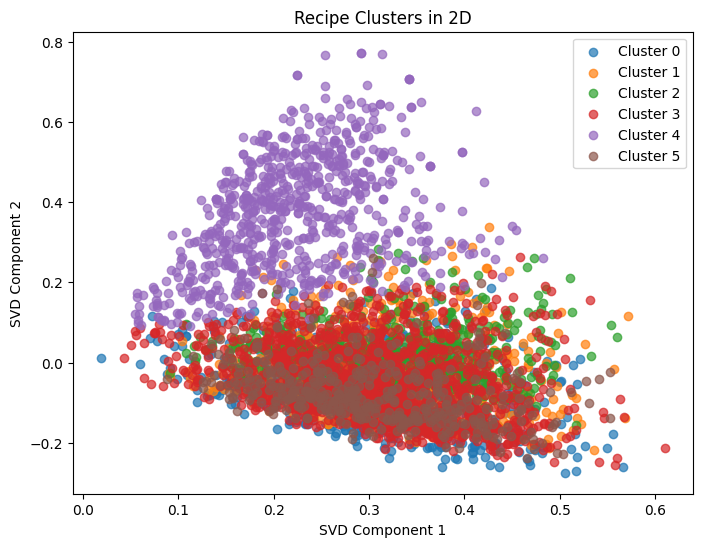

In [21]:
# TODO: TruncatedSVD to reduce the dimensions of our feature space
svd = TruncatedSVD(n_components=2, random_state=42)
X_reduced = svd.fit_transform(X)

# TODO: plot clusters
plt.figure(figsize=(8,6))

colors = cm.get_cmap('tab10', k)  # k = number of clusters
for i in range(k):
    plt.scatter(
        X_reduced[recipe_clusters==i, 0], 
        X_reduced[recipe_clusters==i, 1], 
        label=f'Cluster {i}', 
        alpha=0.7
    )

plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.title("Recipe Clusters in 2D")
plt.legend()
plt.show()

### Interpretation

<span style="color:hotpink">
What does the graph look like ?<br>
Are the clusters well-separated ?
</span>

<span style="color:hotpink;">
The plot shows all recipes in 2D after simplifying their ingredient lists using TruncatedSVD.
Each color is a different cluster.

Observations:

Cluster 4 (purple) is quite separate from the others, so these recipes are likely very different (maybe desserts or baked goods).

The other clusters (0, 1, 2, 3, 5) overlap a lot, which means these recipes share many ingredients and aren’t clearly separated in 2D.

Some clusters stand out more than others, but many recipes have ingredients in common, making it hard to fully separate them.

Conclusion:

The clustering groups recipes in a meaningful way, but since ingredients overlap, the clusters aren’t completely distinct.

Using more clusters or more dimensions might make the separation clearer.
</span>

### Plot Silhouette Plots

We can also check the quality of our clustering by looking at the silhouette plots that we get from calling:<br>
`display_silhouette_plots(vectors, clusters)`.

In [22]:
display_silhouette_plots(recipes_vct, recipe_clusters)

NameError: name 'recipes_vct' is not defined

### Interpretation

<span style="color:hotpink">
How many clusters did you end up with ?<br>
How do they look ?<br>
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

## Recipe Completion

Ok. On to the main event.

Let's create some recipes.

We'll do this using a technique similar to what is used for movie/product recommendations. Given an initial set of ingredients, we'll look at recipes that have similar ingredients and "recommend" additional ingredients.

We already have all of the recipes in our dataset encoded as `tf-idf` vectors. The rest of our algorithm will be something like:
1. Start with an initial set of ingredients
2. Encode ingredients
3. Find a set of recipes that are similar to our list of ingredients
4. Find common ingredients that are in the similar recipes, but not in our list of ingredients
5. Pick representative ingredient to add to recipe
6. Repeat

Let's start.

### 1. Initial list of ingredients

This is just a string with ingredients:

In [ ]:
recipe_seed_str = "tofu" # feel free to change this

### 2. Encode ingredients

Transform the string into a `tf-idf` vector:

In [ ]:
# TODO: transform string into sparse vector

recipe_seed_vct = [0] # change this

### 3. Find similar recipes

The meat of the algorithm. No pun intended.

In order to find similar recipes, we'll first calculate the distance between our current list of ingredients and all recipes in our dataset.

We can start with euclidean distance and later try other kinds, but the overall processing will be the same:

1. Start with an empty list to store distances
2. Loop over the `tf-idf` recipe vectors and for each vector:
   1. Subtract the ingredient list
   2. Square the difference (to square a sparse matrix `A`, use `A.multiply(A)`)
   3. Sum the terms of the result
   4. Take the square root of the sum
   5. Append to distance list
3. Find the indices of the smallest distances (this operation is called `argsort` and will give us the indices of the recipes that are most similar to our list of ingredients)
4. Check the recipes to see if they are indeed similar (`inverse_transform()` the vectors at the indices calculated above)

In [ ]:
# argsort a list (get sequence of indices that would sort the list)
# https://stackoverflow.com/a/3382369
def argsort(L, reverse=False):
  return sorted(range(len(L)), key=L.__getitem__, reverse=reverse)

In [ ]:
# TODO: list to keep distances
recipe_dists = []

# TODO: loop over vectors and append euclidean distances to list

# TODO: argsort list of distances to find indices of similar recipes

# TODO: check first 4 recipes

### 4. Find ingredients to recommend

We have a way to get a set of similar recipes with similar ingredients, and now want to find a *meaningful*, or *representative*, ingredient to add to our ingredients list.

Let's consider ingredients in the $16$ most similar recipes. What we are trying to do is find an ingredient that is in a lot of these recipes, but not yet in our list of ingredients.

There are many possible ways of doing this. We could count the number of times different ingredients show up in these $16$ recipes using Python dictionaries and/or sets, but what we're trying to do here is very similar to what a `TfidfVectorizer` does: calculate relative importance of terms in a series of documents.

Let's re-encode these $16$ recipes using their own separate `TfidfVectorizer`, then sum the importance of each ingredient and look at ingredients with the highest importance scores.

We could re-use the vectors/scores from the original `TfidfVectorizer`, but they're gonna be influenced by the relative frequencies of all of the ingredients that showed up in all of the recipes. Using a separate vectorizer is a little bit more precise.

The steps we need to take are:

1. Separate the $16$ recipes most similar to our list of ingredients
   1. We have lots of representations of our recipes, but `recipes` (list of strings) might be the easiest one to use here
2. Create a new `TfidfVectorizer` and encode the $16$ recipes
3. Sum the resulting vectors to get overall importance scores for each ingredient/token
4. Convert resulting vector to a list using `A.tolist()[0]`
5. `argsort` the importance scores to get sequence of ingredient indices ordered from most to least important
6. Find the most important ingredient that isn't on the ingredient list

In [ ]:
# TODO: Get 16 most similar recipes

# TODO: Encode the 16 recipes

# TODO: Sum the recipe vectors by column to get ingredient importance scores

# TODO: Convert sparse vector to regular list with A.tolist()[0]

# TODO: argsort the importance scores

# TODO: Find most important ingredient not yet on the list of ingredients

### 5. Add ingredient to recipe

This is simply adding a word to `recipe_seed_str`

In [ ]:
# TODO: add the first important ingredient to list of ingredients

### 6. Repeat (Optional)

Now we can repeat this process until we get an empty list of important ingredients: 
1. Encode current recipe
2. Find similar recipes
3. Find important ingredients
4. Add important ingredient

Might be helpful to define a couple of functions, like `find_similar_recipes()` and `find_important_ingredients()`...

Only do this step if you're really curious about experimenting with generating unconventional ingredient lists. It's not going to be graded.

In [ ]:
# TODO: Create find_similar_recipes(ingredients, recipes, vectorizer)

# TODO: Create find_important_ingredients(recipes)

# TODO: Create recipe by repeating calls to find_similar_recipes() and find_important_ingredients()